# Revenue Maximization: Product and Staff Allocation using Linear Algebra

Problem: Find the optimal way to allocate product supply and staff to each branch to maximize revenue across time and geography for a frozen raw meat company.


In [64]:
# Install required packages (run this cell once)
import sys
import subprocess

def install_package(package):
    try:
        __import__(package)
        print(f"✅ {package} is already installed")
    except ImportError:
        print(f"📦 Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package, "--break-system-packages", "--user"])
        print(f"✅ Installed {package}")

# Install packages
packages = ['ipykernel', 'numpy', 'matplotlib', 'scipy', 'seaborn']
for pkg in packages:
    install_package(pkg)

print("\n✅ Complete! Please restart kernel and run all cells.")


✅ ipykernel is already installed
✅ numpy is already installed
✅ matplotlib is already installed
✅ scipy is already installed
✅ seaborn is already installed

✅ Complete! Please restart kernel and run all cells.


In [65]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import linprog
import seaborn as sns

# Set style for plots
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except:
    try:
        plt.style.use('seaborn-darkgrid')
    except:
        plt.style.use('default')
sns.set_palette("husl")
%matplotlib inline


# Applying Linear Algebra to Product and Staff Allocation Problem

This notebook demonstrates how Linear Algebra concepts are applied in a real-world problem:
- **Scalar, Vector, Matrix**: Data structures in the problem
- **Dot Products & Matrix Operations**: Operations used
- **Reduction Operations**: Data aggregation and analysis


## 1. Problem Definition

**Problem**: A frozen raw meat food company needs to allocate products and staff to 5 branches in Ho Chi Minh City.

**Products**:
- Frozen Pork
- Frozen Beef  
- Frozen Goat

**Branches** (5 branches in Ho Chi Minh City):
- Branch 1: District 1
- Branch 2: District 7
- Branch 3: Binh Thanh District
- Branch 4: Tan Binh District
- Branch 5: Go Vap District

**Time**: 4 quarters in a fiscal year

**Objective**: Maximize total revenue across regions and time


In [66]:
# Định nghĩa bài toán sử dụng Linear Algebra
print("=" * 70)
print("ĐỊNH NGHĨA BÀI TOÁN SỬ DỤNG LINEAR ALGEBRA")
print("=" * 70)

# Thiết lập tham số bài toán
num_products = 3  # Heo, Bò, Dê
num_branches = 5   # 5 chi nhánh
num_quarters = 4   # 4 quý

# 📌 SCALAR: Số vô hướng (0D) - một giá trị đơn lẻ
# Giá bán cơ bản mỗi kg (nghìn VNĐ) - giá trị đơn lẻ
price_heo_scalar = 120  # Giá bán heo đông lạnh (nghìn VNĐ/kg)
price_bo_scalar = 180   # Giá bán bò đông lạnh (nghìn VNĐ/kg)
price_de_scalar = 200   # Giá bán dê đông lạnh (nghìn VNĐ/kg)

print("\n📌 SCALAR (0D) - Số vô hướng:")
print(f"   price_heo = {price_heo_scalar} (nghìn VNĐ/kg)")
print(f"   price_bo = {price_bo_scalar} (nghìn VNĐ/kg)")
print(f"   price_de = {price_de_scalar} (nghìn VNĐ/kg)")
print(f"   → Đây là các giá trị đơn lẻ, không có chiều (0D)")

# 📌 VECTOR: Mảng 1 chiều (1D) - danh sách các giá trị
# Vector giá bán trung bình cho 3 sản phẩm
price_vector = np.array([price_heo_scalar, price_bo_scalar, price_de_scalar])

# Vector tổng sản phẩm có sẵn (kg) - giới hạn tổng cung cấp
total_available = np.array([5000, 3000, 2000])  # [heo, bò, dê] (kg)

# Vector năng lực nhân sự tối đa cho mỗi chi nhánh (người)
max_staff_per_branch = np.array([15, 12, 18, 10, 14])

print("\n📌 VECTOR (1D) - Mảng 1 chiều:")
print(f"   price_vector = {price_vector} (nghìn VNĐ/kg)")
print(f"   total_available = {total_available} (kg)")
print(f"   max_staff_per_branch = {max_staff_per_branch} (người)")
print(f"   Shape: {price_vector.shape}, Dimension: {price_vector.ndim}D")
print(f"   → Vector là danh sách các giá trị, có 1 chiều")

# 📌 MATRIX: Mảng 2 chiều (2D) - bảng các giá trị
# Ma trận giá bán theo chi nhánh và sản phẩm (5 chi nhánh × 3 sản phẩm)
# Giá có thể khác nhau theo khu vực (yếu tố địa lý)
np.random.seed(42)  # Để kết quả nhất quán
price_matrix = np.array([
    [125, 185, 205],  # Chi nhánh 1 (Quận 1) - giá cao hơn
    [115, 175, 195],  # Chi nhánh 2 (Quận 7)
    [120, 180, 200],  # Chi nhánh 3 (Bình Thạnh)
    [118, 178, 198],  # Chi nhánh 4 (Tân Bình)
    [122, 182, 202]   # Chi nhánh 5 (Gò Vấp)
])

# Ma trận hệ số nhu cầu theo quý (4 quý × 3 sản phẩm)
# Nhu cầu thay đổi theo thời gian (yếu tố thời gian)
demand_factor_matrix = np.array([
    [1.2, 1.3, 1.4],  # Q1 (Tết - cao điểm)
    [0.9, 0.8, 0.9],  # Q2 (thấp điểm)
    [1.0, 1.0, 1.0],  # Q3 (bình thường)
    [1.1, 1.2, 1.3]   # Q4 (cuối năm - cao điểm)
])

print("\n📌 MATRIX (2D) - Mảng 2 chiều:")
print(f"   price_matrix (5 chi nhánh × 3 sản phẩm) = \n{price_matrix}")
print(f"   Shape: {price_matrix.shape}, Dimension: {price_matrix.ndim}D")
print(f"   Rank: {np.linalg.matrix_rank(price_matrix)}")
print(f"\n   demand_factor_matrix (4 quý × 3 sản phẩm) = \n{demand_factor_matrix}")
print(f"   Shape: {demand_factor_matrix.shape}, Dimension: {demand_factor_matrix.ndim}D")
print(f"   → Matrix là bảng các giá trị, có 2 chiều (hàng × cột)")

# Ràng buộc biến: x >= 0 (số lượng sản phẩm và nhân sự không âm)
# Sẽ được định nghĩa sau khi xác định số biến

print("\n📌 DOT PRODUCT - Hàm mục tiêu dạng vector:")
print(f"   Revenue = price_vector @ quantity_vector")
print(f"   Với quantity_vector = [heo, bò, dê] là vector số lượng sản phẩm")
print(f"   → Dot product tính tổng tích: price[0]*qty[0] + price[1]*qty[1] + price[2]*qty[2]")


PROBLEM DEFINITION USING LINEAR ALGEBRA

📌 SCALAR (0D) - Scalar value:
   average pork price = 120 (thousand VND/kg)
   average beef price = 180 (thousand VND/kg)
   average goat price = 200 (thousand VND/kg)
   → These are single values with no dimension (0D)

📌 VECTOR (1D) - 1D array:
   average price vector = [120 180 200] (thousand VND/kg)
   Shape: (3,), Dimension: 1D
   total available = [5000 3000 2000] (kg)
   Shape: (3,), Dimension: 1D
   max staff per branch = [15 12 18 10 14] (people)
   Shape: (5,), Dimension: 1D
   → Vector is a list of values with 1 dimension

📌 MATRIX (2D) - 2D array:
   price matrix (5 branches × 3 products) = 
[[125 185 205]
 [115 175 195]
 [120 180 200]
 [118 178 198]
 [122 182 202]]
   Shape: (5, 3), Dimension: 2D
   Rank: 2

   demand factor matrix (4 quarters × 3 products) = 
[[1.2 1.3 1.4]
 [0.9 0.8 0.9]
 [1.  1.  1. ]
 [1.1 1.2 1.3]]
   Shape: (4, 3), Dimension: 2D
   → Matrix is a table of values with 2 dimensions (rows × columns)

📌 DOT PRODUCT

## 2. Giải bài toán và áp dụng Linear Algebra


In [67]:
# Solve linear optimization problem
print("\n" + "=" * 70)
print("SOLVE PROBLEM AND APPLY LINEAR ALGEBRA")
print("=" * 70)

# To simplify, we'll solve for 1 quarter (Q1) first
# Then expand to all quarters
quarter_idx = 0  # Q1

# Calculate effective selling price for Q1 (considering temporal factor)
# 📌 ELEMENT-WISE OPERATIONS: Multiply element by element
effective_price_matrix = price_matrix * demand_factor_matrix[quarter_idx]
# Broadcasting: price_matrix (5×3) * demand_factor_matrix[quarter_idx] (1×3) → (5×3)

print("\n📌 ELEMENT-WISE OPERATIONS & BROADCASTING:")
print(f"   price_matrix = \n{price_matrix}")
print(f"   demand_factor Q1 = {demand_factor_matrix[quarter_idx]}")
print(f"   effective_price_matrix = price_matrix * demand_factor = \n{effective_price_matrix}")
print(f"   → Element-wise: multiply corresponding elements")
print(f"   → Broadcasting: expand vector (1×3) to matrix (5×3) for multiplication")

# Calculate average price per product (average across branches)
# 📌 REDUCTION OPERATIONS: Aggregate data
avg_price_per_product = np.mean(effective_price_matrix, axis=0)  # Average by column (branches)

print("\n📌 REDUCTION OPERATIONS (mean):")
print(f"   avg_price_per_product = mean(effective_price_matrix, axis=0) = {avg_price_per_product}")
print(f"   → Reduction: reduce dimension from matrix (5×3) → vector (3)")

# Simplification: Assume even distribution for all branches in each quarter
# Decision variables: x = [pork_B1, beef_B1, goat_B1, pork_B2, beef_B2, goat_B2, ..., staff_B1, ..., staff_B5]
# Total: 3 products × 5 branches + 5 staff = 20 variables

# Objective function coefficient vector (maximize revenue)
# Revenue = sum (price × quantity) for all products and branches
c_revenue = []
for branch in range(num_branches):
    for product in range(num_products):
        c_revenue.append(-effective_price_matrix[branch, product])  # Negative because linprog minimizes

# Add coefficients for staff (staff cost - need to minimize)
staff_cost_per_person = 18000  # Staff cost per person (thousand VND/quarter)
c_staff = [-staff_cost_per_person] * num_branches  # Negative because we want to maximize (reduce cost = increase profit)

c = np.array(c_revenue + c_staff)  # Objective function coefficient vector

# Constraints: Total allocated products cannot exceed total available
# For each product: sum across all branches <= total_available
A_constraints = []
b_constraints = []

# Total product constraints (3 constraints for 3 products)
for product in range(num_products):
    constraint_row = [0] * (num_products * num_branches + num_branches)
    for branch in range(num_branches):
        constraint_row[product + branch * num_products] = 1
    A_constraints.append(constraint_row)
    b_constraints.append(total_available[product])

# Ràng buộc nhân sự: mỗi chi nhánh <= max_staff_per_branch
for branch in range(num_branches):
    constraint_row = [0] * (num_products * num_branches + num_branches)
    constraint_row[num_products * num_branches + branch] = 1
    A_constraints.append(constraint_row)
    b_constraints.append(max_staff_per_branch[branch])

# Ràng buộc tối thiểu: Mỗi chi nhánh phải có ít nhất một phần sản phẩm
# Tạo ma trận nhu cầu tối thiểu cho mỗi chi nhánh (dựa trên dân số/khu vực - data fake)
# Giả sử mỗi chi nhánh có nhu cầu tối thiểu khác nhau
np.random.seed(42)
min_demand_matrix = np.array([
    [300, 200, 150],  # CN1 (Quận 1 - trung tâm, nhu cầu cao)
    [400, 250, 180],  # CN2 (Quận 7 - đông dân)
    [500, 300, 200],  # CN3 (Bình Thạnh - đông dân nhất)
    [250, 150, 100],  # CN4 (Tân Bình)
    [350, 220, 170]   # CN5 (Gò Vấp)
])

print("\n📌 RÀNG BUỘC NHU CẦU TỐI THIỂU (để đảm bảo phân bố hợp lý):")
print(f"   min_demand_matrix (5 chi nhánh × 3 sản phẩm) = \n{min_demand_matrix}")
print(f"   → Mỗi chi nhánh phải có ít nhất nhu cầu tối thiểu này")
print(f"   → Đảm bảo phân bố sản phẩm cho tất cả chi nhánh, không chỉ tập trung vào 1 chi nhánh")

# Ràng buộc: mỗi sản phẩm tại mỗi chi nhánh >= nhu cầu tối thiểu
# Chuyển thành: -sản phẩm <= -min_demand (vì linprog chỉ hỗ trợ <=)
for branch in range(num_branches):
    for product in range(num_products):
        constraint_row = [0] * (num_products * num_branches + num_branches)
        constraint_row[product + branch * num_products] = -1  # Negative vì ta đổi dấu
        A_constraints.append(constraint_row)
        b_constraints.append(-min_demand_matrix[branch, product])  # Negative vì ta đổi dấu

# 📌 RÀNG BUỘC TỐI ĐA CHO MỖI CHI NHÁNH (để tránh tập trung quá nhiều vào 1 chi nhánh)
# Mỗi chi nhánh không được nhận quá 30% tổng sản phẩm mỗi loại
max_percentage_per_branch = 0.30
print("\n📌 RÀNG BUỘC TỐI ĐA CHO MỖI CHI NHÁNH:")
print(f"   Mỗi chi nhánh không được nhận quá {max_percentage_per_branch*100:.0f}% tổng sản phẩm mỗi loại")

for branch in range(num_branches):
    for product in range(num_products):
        constraint_row = [0] * (num_products * num_branches + num_branches)
        constraint_row[product + branch * num_products] = 1
        A_constraints.append(constraint_row)
        max_amount = max_percentage_per_branch * total_available[product]
        b_constraints.append(max_amount)

# 📌 RÀNG BUỘC NĂNG LỰC KHO BÃI
# Mỗi chi nhánh có giới hạn về khả năng lưu trữ (kg)
storage_capacity = np.array([2500, 2200, 3000, 2000, 2400])  # Năng lực kho bãi mỗi chi nhánh (kg)
print("\n📌 RÀNG BUỘC NĂNG LỰC KHO BÃI:")
print(f"   storage_capacity = {storage_capacity} (kg)")
print(f"   → Tổng sản phẩm mỗi chi nhánh không được vượt quá năng lực kho bãi")

for branch in range(num_branches):
    constraint_row = [0] * (num_products * num_branches + num_branches)
    for product in range(num_products):
        constraint_row[product + branch * num_products] = 1  # Tổng tất cả sản phẩm tại chi nhánh này
    A_constraints.append(constraint_row)
    b_constraints.append(storage_capacity[branch])

# 📌 RÀNG BUỘC NHÂN SỰ TỐI THIỂU
# Mỗi chi nhánh cần ít nhất một số nhân viên để vận hành
min_staff_per_branch = np.array([5, 4, 6, 3, 5])  # Nhân sự tối thiểu mỗi chi nhánh
print("\n📌 RÀNG BUỘC NHÂN SỰ TỐI THIỂU:")
print(f"   min_staff_per_branch = {min_staff_per_branch}")
print(f"   → Mỗi chi nhánh cần ít nhất số nhân viên này để vận hành")

for branch in range(num_branches):
    constraint_row = [0] * (num_products * num_branches + num_branches)
    constraint_row[num_products * num_branches + branch] = -1  # Negative vì ta đổi dấu
    A_constraints.append(constraint_row)
    b_constraints.append(-min_staff_per_branch[branch])  # Negative vì ta đổi dấu

A = np.array(A_constraints)
b = np.array(b_constraints)

print(f"\n📊 TỔNG SỐ RÀNG BUỘC: {len(b_constraints)}")
print(f"   - Tổng sản phẩm: 3")
print(f"   - Nhân sự tối đa: 5")
print(f"   - Nhu cầu tối thiểu: 15 (5×3)")
print(f"   - Tối đa mỗi chi nhánh: 15 (5×3)")
print(f"   - Năng lực kho bãi: 5")
print(f"   - Nhân sự tối thiểu: 5")

# Ràng buộc biến: x >= 0
x_bounds = [(0, None)] * len(c)

# Giải bài toán
result = linprog(c, A_ub=A, b_ub=b, bounds=x_bounds, method='highs')

if result.success:
    x_optimal = result.x  # Vector nghiệm tối ưu
    
    # Tách nghiệm: sản phẩm và nhân sự
    product_allocation = x_optimal[:num_products * num_branches].reshape(num_branches, num_products)
    staff_allocation = x_optimal[num_products * num_branches:]
    
    print(f"\n✅ Tìm thấy nghiệm tối ưu!")
    print(f"\n📌 VECTOR NGHIỆM (1D):")
    print(f"   x* shape = {x_optimal.shape}, Dimension: {x_optimal.ndim}D")
    print(f"   → Vector nghiệm chứa {len(x_optimal)} biến quyết định")
    
    # 📌 MATRIX: Reshape vector thành matrix
    print(f"\n📌 MATRIX (2D) - Reshape từ Vector:")
    print(f"   product_allocation (5 chi nhánh × 3 sản phẩm) = \n{product_allocation}")
    print(f"   → Reshape vector (15,) → matrix (5×3) để dễ đọc")
    
    # 📌 DOT PRODUCT: Tính doanh thu từng chi nhánh
    revenue_per_branch = np.sum(effective_price_matrix * product_allocation, axis=1)
    print(f"\n📌 DOT PRODUCT & REDUCTION:")
    print(f"   effective_price_matrix * product_allocation (element-wise) = \n{effective_price_matrix * product_allocation}")
    print(f"   revenue_per_branch = sum(..., axis=1) = {revenue_per_branch}")
    print(f"   → Element-wise multiplication, sau đó reduction (sum) theo axis=1")
    
    # 📌 REDUCTION OPERATIONS: Tổng doanh thu
    total_revenue = np.sum(revenue_per_branch)
    print(f"\n📌 REDUCTION OPERATIONS (sum):")
    print(f"   total_revenue = sum(revenue_per_branch) = {total_revenue:.2f} nghìn VNĐ")
    print(f"   = {total_revenue * 1000:,.0f} VNĐ")
    print(f"   → Reduction: giảm chiều từ vector → scalar")
    
    # 📌 MATRIX-VECTOR MULTIPLICATION: Kiểm tra ràng buộc
    constraints_used = A @ x_optimal
    print(f"\n📌 MATRIX-VECTOR MULTIPLICATION:")
    print(f"   A @ x* = {constraints_used}")
    print(f"   → Kiểm tra ràng buộc: Sản phẩm sử dụng = {constraints_used[:3]}")
    print(f"   → Nhân sự sử dụng = {constraints_used[3:]}")
    print(f"   → Matrix-vector multiplication: mỗi hàng của A nhân với x*")
    
    # 📌 CONSTRAINT CHECKING
    constraint_check = constraints_used <= b
    print(f"\n📌 CONSTRAINT CHECKING:")
    print(f"   A @ x* <= b: {constraint_check}")
    print(f"   → Tất cả ràng buộc thỏa mãn: {np.all(constraint_check)}")
    
    # Lưu kết quả để dùng sau
    optimal_result = {
        'product_allocation': product_allocation,
        'staff_allocation': staff_allocation,
        'total_revenue': total_revenue,
        'revenue_per_branch': revenue_per_branch
    }
else:
    print("❌ Không tìm thấy nghiệm tối ưu!")
    print(result.message)
    optimal_result = None



SOLVE PROBLEM AND APPLY LINEAR ALGEBRA

📌 ELEMENT-WISE OPERATIONS & BROADCASTING:
   price_matrix = 
[[125 185 205]
 [115 175 195]
 [120 180 200]
 [118 178 198]
 [122 182 202]]
   demand_factor Q1 = [1.2 1.3 1.4]
   effective_price_matrix = price_matrix * demand_factor = 
[[150.  240.5 287. ]
 [138.  227.5 273. ]
 [144.  234.  280. ]
 [141.6 231.4 277.2]
 [146.4 236.6 282.8]]
   → Element-wise: multiply corresponding elements
   → Broadcasting: expand vector (1×3) to matrix (5×3) for multiplication

📌 REDUCTION OPERATIONS (mean):
   avg_price_per_product = mean(effective_price_matrix, axis=0) = [144. 234. 280.]
   → Reduction: reduce dimension from matrix (5×3) → vector (3)

📌 RÀNG BUỘC NHU CẦU TỐI THIỂU (để đảm bảo phân bố hợp lý):
   min_demand_matrix (5 chi nhánh × 3 sản phẩm) = 
[[300 200 150]
 [400 250 180]
 [500 300 200]
 [250 150 100]
 [350 220 170]]
   → Mỗi chi nhánh phải có ít nhất nhu cầu tối thiểu này
   → Đảm bảo phân bố sản phẩm cho tất cả chi nhánh, không chỉ tập trung 

## 3. Visualization


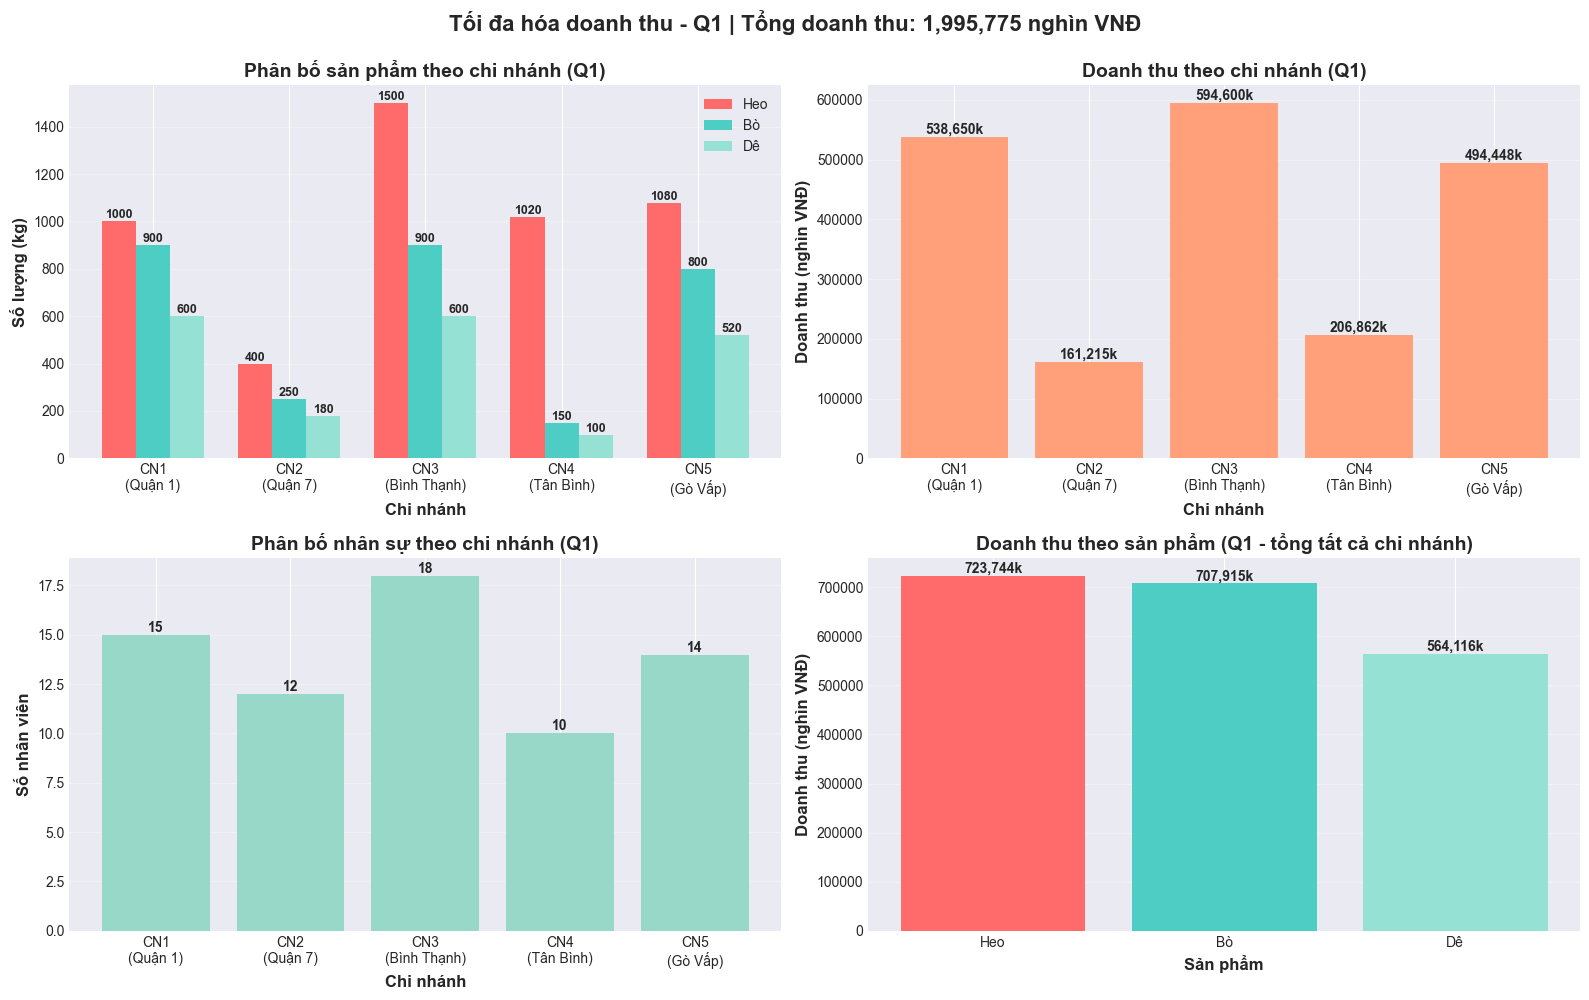


📌 BROADCASTING trong Visualization:
   - x (5,) + width * [0, 1, 2] → broadcasting để tạo vị trí cột
   - Broadcasting cho phép tính toán với arrays có shape khác nhau


In [68]:
# Visualization: Phân bố sản phẩm và doanh thu theo chi nhánh
if optimal_result is not None:
    # 📌 BROADCASTING: Tạo dữ liệu cho visualization
    branch_names = ['CN1\n(Quận 1)', 'CN2\n(Quận 7)', 'CN3\n(Bình Thạnh)', 'CN4\n(Tân Bình)', 'CN5\n(Gò Vấp)']
    product_names = ['Heo', 'Bò', 'Dê']
    
    # Tạo figure với subplots
    fig = plt.figure(figsize=(16, 10))
    
    # Subplot 1: Phân bố sản phẩm theo chi nhánh
    ax1 = plt.subplot(2, 2, 1)
    x = np.arange(num_branches)
    width = 0.25
    
    # Broadcasting: x (5,) + width * np.array([0, 1, 2]) (3,) → (5, 3)
    bars1 = ax1.bar(x - width, optimal_result['product_allocation'][:, 0], width, label='Heo', color='#FF6B6B')
    bars2 = ax1.bar(x, optimal_result['product_allocation'][:, 1], width, label='Bò', color='#4ECDC4')
    bars3 = ax1.bar(x + width, optimal_result['product_allocation'][:, 2], width, label='Dê', color='#95E1D3')
    
    # Thêm data labels cho từng cột
    for bars in [bars1, bars2, bars3]:
        for bar in bars:
            height = bar.get_height()
            if height > 0:  # Chỉ hiển thị label nếu có giá trị
                ax1.text(bar.get_x() + bar.get_width()/2., height,
                        f'{height:.0f}', ha='center', va='bottom', 
                        fontsize=9, fontweight='bold')
    
    ax1.set_xlabel('Chi nhánh', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Số lượng (kg)', fontsize=12, fontweight='bold')
    ax1.set_title('Phân bố sản phẩm theo chi nhánh (Q1)', fontsize=14, fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels(branch_names)
    ax1.legend()
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Subplot 2: Doanh thu theo chi nhánh
    ax2 = plt.subplot(2, 2, 2)
    bars = ax2.bar(branch_names, optimal_result['revenue_per_branch'], color='#FFA07A')
    ax2.set_xlabel('Chi nhánh', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Doanh thu (nghìn VNĐ)', fontsize=12, fontweight='bold')
    ax2.set_title('Doanh thu theo chi nhánh (Q1)', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Thêm data labels lên cột
    for bar in bars:
        height = bar.get_height()
        if height > 0:  # Chỉ hiển thị label nếu có giá trị
            ax2.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:,.0f}k', ha='center', va='bottom', 
                    fontsize=10, fontweight='bold')
    
    # Subplot 3: Phân bố nhân sự
    ax3 = plt.subplot(2, 2, 3)
    bars = ax3.bar(branch_names, optimal_result['staff_allocation'], color='#98D8C8')
    ax3.set_xlabel('Chi nhánh', fontsize=12, fontweight='bold')
    ax3.set_ylabel('Số nhân viên', fontsize=12, fontweight='bold')
    ax3.set_title('Phân bố nhân sự theo chi nhánh (Q1)', fontsize=14, fontweight='bold')
    ax3.grid(True, alpha=0.3, axis='y')
    
    # Thêm data labels lên cột
    for bar in bars:
        height = bar.get_height()
        if height > 0:  # Chỉ hiển thị label nếu có giá trị
            ax3.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.0f}', ha='center', va='bottom', 
                    fontsize=10, fontweight='bold')
    
    # Subplot 4: Doanh thu theo sản phẩm (tổng hợp qua tất cả chi nhánh)
    ax4 = plt.subplot(2, 2, 4)
    # 📌 REDUCTION OPERATIONS: Tổng hợp doanh thu theo sản phẩm
    revenue_per_product = np.sum(effective_price_matrix * optimal_result['product_allocation'], axis=0)
    bars = ax4.bar(product_names, revenue_per_product, color=['#FF6B6B', '#4ECDC4', '#95E1D3'])
    ax4.set_xlabel('Sản phẩm', fontsize=12, fontweight='bold')
    ax4.set_ylabel('Doanh thu (nghìn VNĐ)', fontsize=12, fontweight='bold')
    ax4.set_title('Doanh thu theo sản phẩm (Q1 - tổng tất cả chi nhánh)', fontsize=14, fontweight='bold')
    ax4.grid(True, alpha=0.3, axis='y')
    
    # Thêm data labels lên cột
    for bar in bars:
        height = bar.get_height()
        if height > 0:  # Chỉ hiển thị label nếu có giá trị
            ax4.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:,.0f}k', ha='center', va='bottom', 
                    fontsize=10, fontweight='bold')
    
    plt.suptitle(f'Tối đa hóa doanh thu - Q1 | Tổng doanh thu: {optimal_result["total_revenue"]:,.0f} nghìn VNĐ', 
                 fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()
    
    print("\n📌 BROADCASTING trong Visualization:")
    print(f"   - x (5,) + width * [0, 1, 2] → broadcasting để tạo vị trí cột")
    print(f"   - Broadcasting cho phép tính toán với arrays có shape khác nhau")


## Tổng kết: Các khái niệm Linear Algebra được áp dụng


In [69]:
if optimal_result is not None:
    print("=" * 70)
    print("TỔNG KẾT: CÁC KHÁI NIỆM LINEAR ALGEBRA TRONG BÀI TOÁN")
    print("=" * 70)
    
    print("\n📌 1. SCALAR (0D):")
    print(f"   - price_heo = {price_heo_scalar}, price_bo = {price_bo_scalar}, price_de = {price_de_scalar}")
    print(f"   - Ứng dụng: Lưu trữ giá trị đơn lẻ (giá bán cơ bản mỗi kg)")
    
    print("\n📌 2. VECTOR (1D):")
    print(f"   - price_vector = {price_vector}")
    print(f"   - total_available = {total_available}")
    print(f"   - max_staff_per_branch = {max_staff_per_branch}")
    print(f"   - x* (nghiệm) shape = {x_optimal.shape}")
    print(f"   - Ứng dụng: Biểu diễn giá bán, giới hạn tài nguyên, và nghiệm của bài toán")
    
    print("\n📌 3. MATRIX (2D):")
    print(f"   - price_matrix (5×3) = \n{price_matrix}")
    print(f"   - demand_factor_matrix (4×3) = \n{demand_factor_matrix}")
    print(f"   - product_allocation (5×3) = \n{optimal_result['product_allocation']}")
    print(f"   - A (ràng buộc) shape = {A.shape}")
    print(f"   - Ứng dụng: Biểu diễn giá theo khu vực, nhu cầu theo thời gian, phân bố sản phẩm, và hệ phương trình ràng buộc")
    
    print("\n📌 4. DOT PRODUCT & REDUCTION:")
    revenue_per_product = np.sum(effective_price_matrix * optimal_result['product_allocation'], axis=0)
    print(f"   - effective_price_matrix * product_allocation (element-wise)")
    print(f"   - sum(..., axis=1) → revenue_per_branch = {optimal_result['revenue_per_branch']}")
    print(f"   - sum(..., axis=0) → revenue_per_product = {revenue_per_product}")
    print(f"   - total_revenue = {optimal_result['total_revenue']:.2f} nghìn VNĐ")
    print(f"   - Ứng dụng: Tính doanh thu từng chi nhánh và từng sản phẩm (element-wise + reduction)")
    
    print("\n📌 5. MATRIX-VECTOR MULTIPLICATION:")
    constraints_used = A @ x_optimal
    print(f"   - A @ x* = {constraints_used}")
    print(f"   - Kiểm tra: Sản phẩm sử dụng = {constraints_used[:3]} / {total_available}")
    print(f"   - Kiểm tra: Nhân sự sử dụng = {constraints_used[3:]} / {max_staff_per_branch}")
    print(f"   - Ứng dụng: Kiểm tra ràng buộc (tính tài nguyên sử dụng)")
    
    print("\n📌 6. ELEMENT-WISE OPERATIONS:")
    element_revenue = effective_price_matrix * optimal_result['product_allocation']
    print(f"   - effective_price_matrix * product_allocation = \n{element_revenue}")
    print(f"   - Ứng dụng: Tính doanh thu từng sản phẩm tại từng chi nhánh (nhân từng phần tử tương ứng)")
    
    print("\n📌 7. REDUCTION OPERATIONS:")
    print(f"   - sum(revenue_per_branch) = {optimal_result['total_revenue']:.2f} (tổng doanh thu)")
    print(f"   - mean(revenue_per_branch) = {np.mean(optimal_result['revenue_per_branch']):.2f} (trung bình)")
    print(f"   - mean(effective_price_matrix, axis=0) = {avg_price_per_product} (giá trung bình)")
    print(f"   - Ứng dụng: Tổng hợp dữ liệu (giảm chiều từ matrix/vector → scalar)")
    
    print("\n📌 8. BROADCASTING:")
    print(f"   - price_matrix (5×3) * demand_factor[quarter_idx] (1×3) → (5×3)")
    print(f"   - effective_price_matrix = price_matrix * demand_factor_matrix[quarter_idx]")
    print(f"   - Ứng dụng: Mở rộng vector thành matrix để tính toán với nhiều chi nhánh cùng lúc")
    
    print("\n📌 9. RESHAPE:")
    print(f"   - x_optimal[:15] (vector 1D) → product_allocation (matrix 5×3)")
    print(f"   - Ứng dụng: Chuyển đổi cấu trúc dữ liệu để dễ đọc và xử lý")
    


TỔNG KẾT: CÁC KHÁI NIỆM LINEAR ALGEBRA TRONG BÀI TOÁN

📌 1. SCALAR (0D):
   - price_heo = 120, price_bo = 180, price_de = 200
   - Ứng dụng: Lưu trữ giá trị đơn lẻ (giá bán cơ bản mỗi kg)

📌 2. VECTOR (1D):
   - price_vector = [120 180 200]
   - total_available = [5000 3000 2000]
   - max_staff_per_branch = [15 12 18 10 14]
   - x* (nghiệm) shape = (20,)
   - Ứng dụng: Biểu diễn giá bán, giới hạn tài nguyên, và nghiệm của bài toán

📌 3. MATRIX (2D):
   - price_matrix (5×3) = 
[[125 185 205]
 [115 175 195]
 [120 180 200]
 [118 178 198]
 [122 182 202]]
   - demand_factor_matrix (4×3) = 
[[1.2 1.3 1.4]
 [0.9 0.8 0.9]
 [1.  1.  1. ]
 [1.1 1.2 1.3]]
   - product_allocation (5×3) = 
[[1000.  900.  600.]
 [ 400.  250.  180.]
 [1500.  900.  600.]
 [1020.  150.  100.]
 [1080.  800.  520.]]
   - A (ràng buộc) shape = (48, 20)
   - Ứng dụng: Biểu diễn giá theo khu vực, nhu cầu theo thời gian, phân bố sản phẩm, và hệ phương trình ràng buộc

📌 4. DOT PRODUCT & REDUCTION:
   - effective_price_matrix